<a href="https://colab.research.google.com/github/stevegbrooks/big-portfolio-learner/blob/time_series_exploration/big_portfolio_learner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np 
import json
import matplotlib
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from datetime import datetime
import glob
import seaborn as sns
import re
import os

In [ ]:
## If boto3 not already installed uncomment the following:
#!pip3 install boto3

In [ ]:
import boto3
from botocore import UNSIGNED

from botocore.config import Config

s3 = boto3.resource('s3', config=Config(signature_version=UNSIGNED))
s3.Bucket('cis545project').download_file('data/stock_data.zip', 'stock_data.zip')

In [ ]:
%%capture

in_dir = "stock_data"

os.mkdir("/content/"+ in_dirstock_data)
!unzip /content/stock_data.zip -d /content/$in_dir
!rm -f $in_dir/.gitempty

# Section 1: Exploratory Data Analysis of the Stock Data

The schema of the stock data is as below:

In [125]:
import random
stock_data_files = os.listdir(in_dir)

# head of a random file
pd.read_csv(os.path.join(in_dir, stock_data_files[random.randrange(len(stock_data_files))])).head(5)

,symbol,timestamp,open,high,low,close,adjusted_close,volume,dividend_amount,split_coefficient
0,TVTX,2021-12-03,28.24,28.240,27.03,27.61,27.61,544473,0.0,1.0
1,TVTX,2021-12-02,28.26,28.410,27.34,28.08,28.08,374470,0.0,1.0
2,TVTX,2021-12-01,28.50,29.585,27.34,27.99,27.99,666855,0.0,1.0
3,TVTX,2021-11-30,28.26,29.300,27.89,28.55,28.55,1238231,0.0,1.0
4,TVTX,2021-11-29,29.51,30.180,28.38,28.47,28.47,469784,0.0,1.0


### First, lets look at the number of rows of data across within each year for each stock

In [154]:
def add_year_col(df: pd.DataFrame, timestamp_col: str) -> pd.DataFrame:
  """ 
  Assumes the input df has a column that needs to be converted into datetime
  using datetime.strptime function and "%Y-%m-%d" format
  """
  new_col_name = timestamp_col + '_as_dt'
  df[new_col_name] = df[timestamp_col].apply(lambda x: datetime.strptime(x, "%Y-%m-%d"))
  if len(df[new_col_name].unique()) != len(df[timestamp_col].unique()):
    raise Exception("error in timestamp parsing")
  df['year'] = pd.to_numeric(df[new_col_name].dt.year)
  return df


In [179]:
rows_per_year = dict()

for data_file in stock_data_files:
  stock_data = pd.read_csv(os.path.join(in_dir, data_file))
  stock_data = add_year_col(stock_data, "timestamp")
  rows_per_year[data_file] = dict(stock_data.groupby(by = 'year').size())

### We are interested in data from the years from 2001 to 2021, inclusive.

In [169]:
analysis_years = range(2001, 2022)

27 stocks have data in each of the years in range(2001, 2022)
There are 4 unique rows-per-year patterns among those stocks


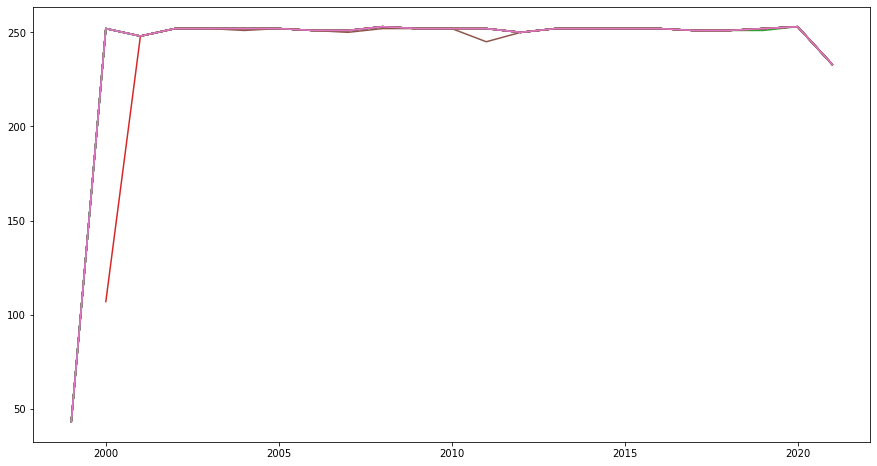

In [202]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 15, 8

count_unique = 1
stocks_with_all_analysis_yrs = []
last = None

for i, (key, rows_dict) in enumerate(rows_per_year.items()):
  if all(analysis_year in rows_dict for analysis_year in analysis_years):
    stocks_with_all_analysis_yrs.append(key)
    if last is None: last = rows_dict
    elif rows_dict != last: count_unique += 1
    as_list = sorted(rows_dict.items())
    year, row_count = zip(*as_list)
    plt.plot(year, row_count)

print(len(stocks_with_all_analysis_yrs), "stocks have data in each of the years in", analysis_years)
print("There are", count_unique, "unique rows-per-year patterns among those stocks")

### Then, we examine the time series data of adjusted closing price per day over this span.

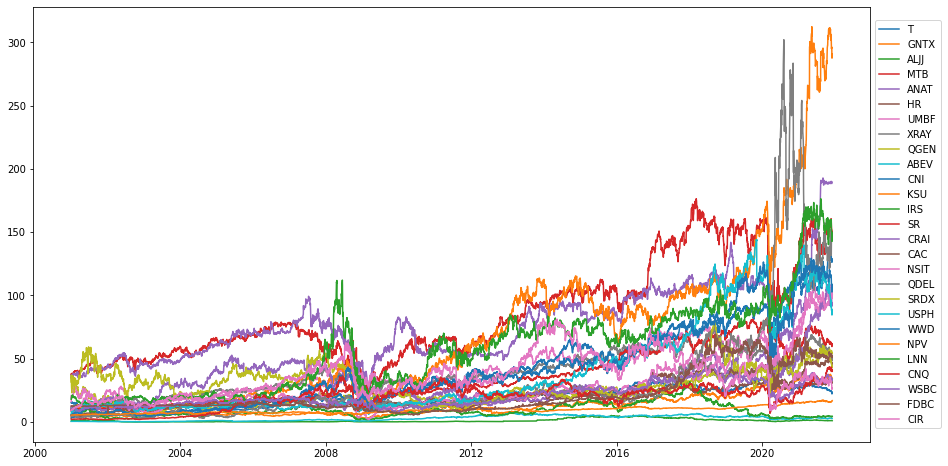

In [203]:
for i, data_file in enumerate(stocks_with_all_analysis_yrs):
  stock_data = pd.read_csv(os.path.join(in_dir, data_file))
  stock_data = add_year_col(stock_data, "timestamp")
  stock_data = stock_data.loc[stock_data.year >= analysis_years[0]]
  plt.plot(stock_data.timestamp_as_dt, stock_data.adjusted_close, label = stock_data.symbol[0])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))